# Customer Geography Analysis

# Problem Statement

We have been asked to dive into the data to understand where our customers are coming from and how they are spending across the United Kingdom. The goal is to help our team gain a clear picture of the customer landscape so we can make more informed decisions about where to focus our efforts.

The dataset we are working with includes:
- Each customer address
- Their total spending to date

From this, we are going to explore two main questions:
1. **Which cities might be underserved?** In other words, are there areas with lower spending that could represent opportunities for growth?
2. **Is our customer base primarily London-centric, or do we have strong engagement across other regions?** Knowing this will help us decide if we are reaching the audience we want, or if there are areas where we could expand our reach.

In this analysis, I will break down the data to uncover patterns in spending and geographical distribution, ultimately helping us better understand where our customers are and how we can support their needs more effectively.


# Goals

We have to calculate customer spend by city, and use this data to compare London with the rest of the UK. Here's what we need to do in our analysis:

- Explore the customer address data
- Come up with a method to extract the city from the address field
- Calculate total spend per city
- Analyze results to understand the spending of London customers vs. those outside London


**Our final output should be a dataset with one row for each city, including the total customer spend for that city**

In [1]:
import pandas as pd
customers = pd.read_csv("../data/addresses.csv")
print(customers.head(10))

   company_id                                            address  total_spend
0           1  APARTMENT 2,\n52 BEDFORD ROAD,\nLONDON,\nENGLA...         5700
1           2           107 SHERINGHAM AVENUE,\nLONDON,\nN14 4UJ         4700
2           3  43 SUNNINGDALE,\nYATE,\nBRISTOL,\nENGLAND,\nBS...         5900
3           4  HAWESWATER HOUSE,\nLINGLEY MERE BUSINESS PARK,...         7200
4           5  AMBERFIELD BARN HOUSE AMBER LANE,\nCHART SUTTO...         4600
5           6  FIRST FLOOR CEF BUILDING,\nBROOMHILL WAY,\nTOR...         4600
6           7  37 BEVERLEY ROAD,\nDRIFFIELD,\nENGLAND,\nYO25 6RZ         7300
7           8  B82 ALBION RIVERSIDE BUILDING,\n8 HESTER ROAD,...         6100
8           9  Flat 27, Domelton House,\nIron Mill Road,\nLon...         4200
9          10  34 BROOKSIDE ESTATE,\nCHALGROVE,\nOXFORD,\nUNI...         5800


In [2]:
print(customers.shape)

(100000, 3)


## Checking our Data

Lets check our data for missing values.

In [3]:
customers.isnull().sum()

company_id       0
address        968
total_spend      0
dtype: int64

We have 968 missing addresses and if possible we could ask the stakeholders to check if we might have these addresses elsewhere. But if we can't get these addresses, then we can drop these rows. We can also categorize these missing addresses as 'Other' but since we have a small number of missing addresses, we can go ahead and drop it.

In [4]:
customers.dropna(subset=["address"], inplace=True)

Lets check the total_spend column for negative values

In [5]:
customers['total_spend'].describe()

count    99032.000000
mean      4951.673197
std       1500.642398
min          0.000000
25%       3900.000000
50%       5000.000000
75%       6000.000000
max      11700.000000
Name: total_spend, dtype: float64

No strange data. That's great!

## Extracting Cities from Address Column

In [6]:
# print(customers['address'].head())

In [7]:
for address in customers["address"].head():
 print(address, "\n")

APARTMENT 2,
52 BEDFORD ROAD,
LONDON,
ENGLAND,
SW4 7HJ 

107 SHERINGHAM AVENUE,
LONDON,
N14 4UJ 

43 SUNNINGDALE,
YATE,
BRISTOL,
ENGLAND,
BS37 4HZ 

HAWESWATER HOUSE,
LINGLEY MERE BUSINESS PARK,
LINGLEY GREEN AVENUE,
GREAT SANKEY, WARRINGTON,
WA5 3LP 

AMBERFIELD BARN HOUSE AMBER LANE,
CHART SUTTON,
MAIDSTONE,
ENGLAND,
ME17 3SF 



In [8]:
customers['address_clean'] = customers['address'].str.upper() # To make addresses case consistent

In [9]:
# Check how many addresses contain 'LONDON,'
len(customers[customers['address_clean'].str.contains('LONDON,')])

20831

In [10]:
# Lets check how many lines are there in different addresses
customers['address_lines'] = (
customers['address_clean'].str.split('\n').apply(len) # Split addresses by new line and create a list of lines, then calculate the length of each list to get the number of lines in an address
)

In [11]:
customers['address_lines'].value_counts().sort_index()

1        6
2       52
3     3284
4    35850
5    45931
6    13909
Name: address_lines, dtype: int64

In [12]:
print(customers.loc[customers["address_lines"] == 1, "address_clean"])

17789                      FALKIRK
31897                   HADDINGTON
61750          CREAG BHAITHEACHAIN
75330                     NEWMILNS
78045    REDCLOAK FARM, STONEHAVEN
90897     REFER TO PARENT REGISTRY
Name: address_clean, dtype: object


In [13]:
print((
    customers[customers["address_lines"] == 2]
    .sample(5, random_state=42)
    ["address_clean"])
)

39443                                    FORFAR,\nANGUS
80846                        12 HOPE STREET,\nEDINBURGH
95979    BRANCH REGISTRATION,\nREFER TO PARENT REGISTRY
23563    BRANCH REGISTRATION,\nREFER TO PARENT REGISTRY
81155                             PO BOX 2230,\nGLASGOW
Name: address_clean, dtype: object


Now we have several options for proceeding with our analysis:

- **Apply a rule based on address length:** For example, in a 5-line address, assume the city is in the 4th line; for a 6-line address, use the 5th line, and so on. This approach may be error-prone due to the variability in address formats.
- **Use a predefined list of cities:** Look up each address against a list of city names to determine if it matches a specific city.
- **Extract the postcode from each address:** Identify the postcode within each address and cross-reference it with a national database (which we would need to obtain and confirm for permitted use).


We are going to copy and paste the list of cities from a website into an Excel file and import it here.

In [14]:
cities = pd.read_csv("../data/cities.csv", header=None, names=["city"])
cities.head()

,city
0,England
1,Bath
2,Birmingham*
3,Bradford*
4,Brighton & Hove


In [15]:
# Cleaning Up
countries_to_remove = ["England", "Scotland", "Wales", "Northern Ireland"]

print(len(cities))
cities_to_remove = cities[cities["city"].isin(countries_to_remove)].index
cities = cities.drop(index=cities_to_remove)
print(len(cities))

80
76


In [16]:
# Remove asterisks and uppercase
cities["city"] = cities["city"].str.replace("*", "", regex=False)
cities["city"] = cities["city"].str.upper()

cities.head()

,city
1,BATH
2,BIRMINGHAM
3,BRADFORD
4,BRIGHTON & HOVE
5,BRISTOL


In [17]:
# Create a city column if address contains a City from our list of cities
for city in cities["city"].values:
    customers.loc[customers["address_clean"].str.contains(f"\n{city},"), "city"] = city

In [18]:
# Categorize NULL values as 'Other'
customers["city"].fillna("OTHER", inplace=True)
customers.head()

,company_id,address,total_spend,address_clean,address_lines,city
0,1,"APARTMENT 2,\n52 BEDFORD ROAD,\nLONDON,\nENGLA...",5700,"APARTMENT 2,\n52 BEDFORD ROAD,\nLONDON,\nENGLA...",5,LONDON
1,2,"107 SHERINGHAM AVENUE,\nLONDON,\nN14 4UJ",4700,"107 SHERINGHAM AVENUE,\nLONDON,\nN14 4UJ",3,LONDON
2,3,"43 SUNNINGDALE,\nYATE,\nBRISTOL,\nENGLAND,\nBS...",5900,"43 SUNNINGDALE,\nYATE,\nBRISTOL,\nENGLAND,\nBS...",5,BRISTOL
3,4,"HAWESWATER HOUSE,\nLINGLEY MERE BUSINESS PARK,...",7200,"HAWESWATER HOUSE,\nLINGLEY MERE BUSINESS PARK,...",5,OTHER
4,5,"AMBERFIELD BARN HOUSE AMBER LANE,\nCHART SUTTO...",4600,"AMBERFIELD BARN HOUSE AMBER LANE,\nCHART SUTTO...",5,OTHER


In [19]:
customers["city"].value_counts().head(20)

OTHER            54458
LONDON           20762
MANCHESTER        1902
BIRMINGHAM        1866
GLASGOW           1273
BRISTOL           1150
LEEDS             1040
EDINBURGH         1038
LEICESTER          905
NOTTINGHAM         838
LIVERPOOL          838
CARDIFF            797
SHEFFIELD          706
COVENTRY           553
MILTON KEYNES      493
SOUTHAMPTON        477
NORWICH            449
BRADFORD           417
BELFAST            416
PRESTON            406
Name: city, dtype: int64

An important thing to note is that more than 50% of our data is in the 'Other' category

In [20]:
sample_other = customers[customers["city"] == "OTHER"].sample(5, random_state=42)
for address in sample_other["address_clean"].values:
    print(address, "\n")

82 CROSSE COURTS,
BASILDON,
ENGLAND,
SS15 5JE 

70 NORMAN CRESCENT,
PINNER,
ENGLAND,
HA5 3QL 

23 STATION ROAD,
GERRARDS CROSS,
BUCKINGHAMSHIRE,
ENGLAND,
SL9 8ES 

5 STEWARTS PARK AVENUE,
MARTON,
MIDDLESBROUGH,
CLEVELAND,
UNITED KINGDOM,
TS4 3FD 

FIRST FLOOR,
6 YORK STREET,
TWICKENHAM,
ENGLAND,
TW1 3LD 



In [21]:
# Comparing number of cities in customer data with the number of cities in our City list
print("{0} cities in customer data".format(customers["city"].nunique()))
print("{0} cities in city list".format(len(cities)))

75 cities in customer data
76 cities in city list


In [22]:
# Checking for discrepancies above
set(cities["city"]) - set(customers["city"])

{'KINGSTON-UPON-HULL'}

In [23]:
customers[customers["address_clean"].str.contains("\nKINGSTON,")]
customers[customers["address_clean"].str.contains("\nHULL,")]

,company_id,address,total_spend,address_clean,address_lines,city
455,456,"349 BEVERLEY ROAD,\nANLABY,\nHULL,\nENGLAND,\n...",3800,"349 BEVERLEY ROAD,\nANLABY,\nHULL,\nENGLAND,\n...",5,OTHER
1139,1140,"90 CALVERT LANE,\nHULL,\nENGLAND,\nHU4 6BJ",6000,"90 CALVERT LANE,\nHULL,\nENGLAND,\nHU4 6BJ",4,OTHER
1822,1823,"ACER GLADE BLACK TUP LANE,\nARNOLD,\nHULL,\nEN...",4600,"ACER GLADE BLACK TUP LANE,\nARNOLD,\nHULL,\nEN...",5,OTHER
1831,1832,"10 GORDON STREET,\nHULL,\nENGLAND,\nHU3 3HN",5300,"10 GORDON STREET,\nHULL,\nENGLAND,\nHU3 3HN",4,OTHER
1921,1922,"70 WRIGHT STREET,\nHULL,\nENGLAND,\nHU2 8JD",6100,"70 WRIGHT STREET,\nHULL,\nENGLAND,\nHU2 8JD",4,OTHER
...,...,...,...,...,...,...
98479,98480,"31-38 QUEEN STREET,\nHULL,\nENGLAND,\nHU1 1UU",4500,"31-38 QUEEN STREET,\nHULL,\nENGLAND,\nHU1 1UU",4,OTHER
98886,98887,"13 SALMON GROVE,\nHULL,\nEAST YORKSHIRE,\nENGL...",5000,"13 SALMON GROVE,\nHULL,\nEAST YORKSHIRE,\nENGL...",5,OTHER
99196,99197,"22 19TH AVENUE,\nHULL,\nENGLAND,\nHU6 8HF",5900,"22 19TH AVENUE,\nHULL,\nENGLAND,\nHU6 8HF",4,OTHER
99434,99435,"F14 THE BLOC SPRINGFIELD WAY,\nANLABY,\nHULL,\...",3100,"F14 THE BLOC SPRINGFIELD WAY,\nANLABY,\nHULL,\...",6,OTHER


Google Search shows that Kingston-Upon-Hill is also known as Hull. We can manually fix this in our code. We can also take a deeper dive into our data to similarly fix other cities categorized as 'Other' that can be corrected.

In [24]:
customers.loc[customers["address_clean"].str.contains("\nHULL,"), "city"] = "HULL"


## Answering the Problem Statement

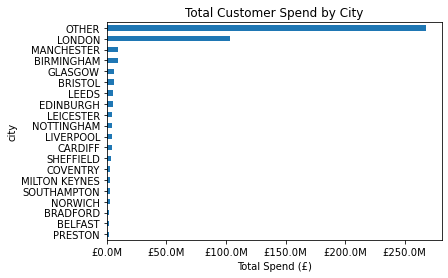

In [25]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Function to format numbers in millions
def millions(x, pos):
    return f'£{x * 1e-6:.1f}M'  # Convert to millions and format to one decimal place

# Custom formatter to display values in millions
formatter = FuncFormatter(millions)

# Create a new figure and axis for the plot
fig, axis = plt.subplots()

# Calculate the top 20 cities by total customer spend
top_20_spend = (
    customers.groupby("city")["total_spend"].sum()
    .nlargest(20)
    .sort_values(ascending=True)
)

# Create a bar plot
top_20_spend.plot.barh(ax=axis)

# Apply the formatter to the x-axis and add labels
axis.xaxis.set_major_formatter(formatter)
axis.set(
    title="Total Customer Spend by City",
    xlabel="Total Spend (£)"
)

plt.show()

Here we see that the 'Other' category makes up a large portion of the Customer Spend. We can maybe look inot this later and categorize some large towns as well using a similar process that we followed for cities to get a better look into this category. For now, I'm going to compare London against the rest of the country.

In [26]:
print("Total spend for all customers:")
print(customers["total_spend"].sum())

Total spend for all customers:
490374100


In [27]:
print("Total spend for London customers:")
print(customers.loc[customers["city"] == "LONDON", "total_spend"].sum())

Total spend for London customers:
103042800


In [28]:
print("Total spend outside London:")
print(customers.loc[customers["city"] != "LONDON", "total_spend"].sum())
print("Total spend outside London (excluding OTHER):")
print(customers.loc[customers["city"].isin(["LONDON", "OTHER"]) == False, "total_spend"].sum())


Total spend outside London:
387331300
Total spend outside London (excluding OTHER):
119468400


## Conclusion

- When comparing only large cities:
  - **London** generated **£103 million** in sales.
  - All other large cities combined generated **£119 million**.

- Our customer base is clearly **London-centric**, with the most spending seen in **Manchester, Birmingham,** and **Glasgow** outside of London.

- These cities are also the most populated outside London, but **spending patterns don’t neccessarily correlate with population size**.
  - **Leeds** has a high population but lower spending, which suggests our customer spending doesn’t directly reflect distribution of population.
